In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [8]:
# Load the bike rentals dataset - cleaned version to pandas data frame
df_bikes = pd.read_csv("data/bike_rentals_cleaned.csv")
print(f"df_bikes shape: {df_bikes.shape}")

# Display the first five rows
df_bikes.head()

df_bikes shape: (731, 13)


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into X and y, target columns is 'cnt': Number of bikes rented for a given day
X = df_bikes.iloc[:, :-1]
y = df_bikes.iloc[:, -1]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

print(f"X train shape: {X_train.shape}, X test shape: {X_test.shape}")

X train shape: (548, 12), X test shape: (183, 12)


## Building Gradient Boosting Model From Scratch

Here are the steps for building a gradient boosting machine learning model from scratch.

#### Step 1: Fit the data into the decision tree 
You may use a decision tree stump, which has a **max_depth** value of 1, or a decision tree with a **max_depth** value of 2 or 3. The initial decision tree, called a **base learner** should not be fine tuned for accuracy.

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)

# Fit the model on to X train and y train
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

#### Step 2: Make predictions with the **training set**
Instead of making predictions with the test set, predictions in gradient boosting are initially made with the training set. 

- Aim is to compute residuals while still in the training phase. 

In [11]:
y_train_pred = tree_1.predict(X_train)

#### Step 3: Compute the residuals
The residuals are the differences between the predictions and the target column.

In [12]:
# The residuals are defined as y2_train, because they are the new target column for the next tree
y2_train = y_train - y_train_pred
y2_train[:5]

203   -1183.145833
634    1132.343558
544     278.343558
12    -1207.743169
171     366.854167
Name: cnt, dtype: float64

#### Step 4: Fit the new tree on the residuals
Fitting a new tree on the residuals is different than fitting a model on the training set. The primary difference is in the predictions. In the bike rentals dataset, when fitting a new tree on the residuals, we should progressively get smaller numbers.

- Initialize a new tree and fit on **X_train** and the residuals, **y2_train**

In [13]:
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)

tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

#### Step 5: Repeat Steps 2-4
As the process continues, the residuals should gradually approach 0 from the positive and negative direction. The iterations continue for the number of estimators, **n_estimators**.

In [15]:
y2_train_pred = tree_2.predict(X_train)

y3_train = y2_train - y2_train_pred

tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

This process may continue for dozens, hundreds or thousands of trees. It will take more than a few trees to transform a weak learner into a strong learner. Since our goal is to understand how gradient boosting works behind the scenes, we will move on to next step.

#### Step 6: Sum the results
Summing the results requires making predictions for each tree with the test set as follows:

In [16]:
y1_pred = tree_1.predict(X_test)
y2_pred = tree_2.predict(X_test)
y3_pred = tree_3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred
y_pred[:5]

array([4710.19173509, 4307.72376923, 3719.78786666, 3888.39768662,
       1865.38520272])

#### Step 7: Compute MSE 

In [17]:
from sklearn.metrics import mean_squared_error as MSE 

np.sqrt(MSE(y_test, y_pred))

911.0479538776444

Not bad for a weak learner that isn't yet strong. Now let's try to obtain the same result using scikit-learn.

## Building Gradient Boosting Model in Scikit-Learn

The advantage of using **GradientBoostingRegressor** is that it is much faster to build and easier to implement.

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=2)

gb_reg.fit(X_train, y_train)

y_pred = gb_reg.predict(X_test)

np.sqrt(MSE(y_test, y_pred))

911.0479538776439

The result is the same to **11 decimal places!**. 
- The point of gradient boosting is to build a model with enough trees to transform a weak learner into a strong learner. This is easily done by changing **n_estimators**, the number of iterations, to a much larger number.

In [19]:
# Lets try to score a GradientBoostingRegressor with 30 estimators

gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=30, learning_rate=1.0, random_state=2)

gb_reg.fit(X_train, y_train)

y_pred = gb_reg.predict(X_test)

np.sqrt(MSE(y_test, y_pred))

857.1072323426944

The score is an improvement. Now let's look at 300 estimators.

In [20]:
gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=1.0, random_state=2)

gb_reg.fit(X_train, y_train)

y_pred = gb_reg.predict(X_test)

np.sqrt(MSE(y_test, y_pred))

936.3617413678853

The score has gotten worse. Whenever you get a surprise result, it's worth double-checking the code. We changed **learning_rate** without saying much about it. So let's find out what happens if we use the scikit-learn default value for the learning rate.

In [21]:
gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)

gb_reg.fit(X_train, y_train)

y_pred = gb_reg.predict(X_test)

np.sqrt(MSE(y_test, y_pred))

653.7456840231495

By using the Scikit-Learn default for the **learning_rate** hyperparameter, the score is improved from 936 to 654. In the next section, let's deep dive into gradient boosting hyperparameters with a focus on the learning_rate hyperparameter.

## Gradient Boosting Hyperparameters

`learning_rate`: Limits the influence of individual trees. Determining an optimal learning_rate value requires varying investigation of **n_estimators**.

In [41]:
def calc_score_for_varying_learningrates(learning_rates, est_count, mdepth=2):
    rmse_values = []

    for rate in learning_rates:
        gb_reg = GradientBoostingRegressor(max_depth=mdepth, n_estimators=est_count, learning_rate=rate, random_state=2)
        gb_reg.fit(X_train, y_train)
        y_pred = gb_reg.predict(X_test)
        rmse = np.sqrt(MSE(y_test, y_pred))
        rmse_values.append(rmse)
        #print(f"Learning Rate: {rate} , Score: {rmse} ")
    
    return rmse_values


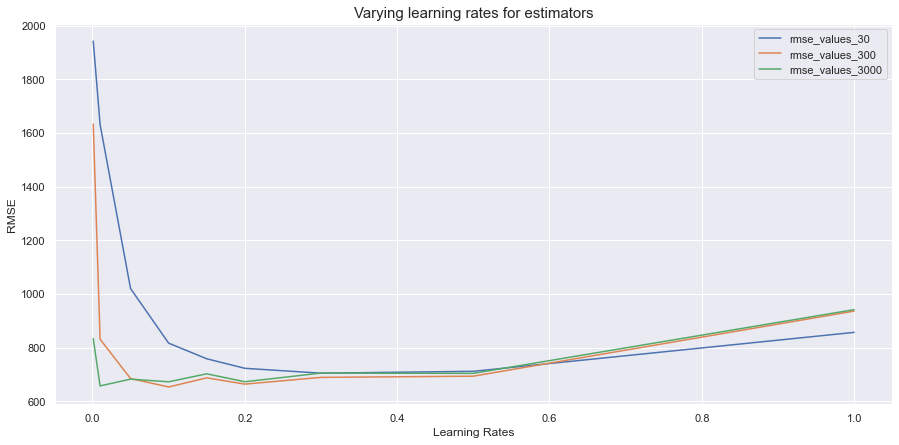

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]

rmse_values_30 = calc_score_for_varying_learningrates(learning_rates, est_count=30)
rmse_values_300 = calc_score_for_varying_learningrates(learning_rates, est_count=300)
rmse_values_3000 = calc_score_for_varying_learningrates(learning_rates, est_count=3000)

plt.figure(figsize=(15, 7))
plt.title("Varying learning rates for estimators", fontsize=15)

plt.grid("on")

plt.plot(learning_rates, rmse_values_30, label="rmse_values_30")
plt.plot(learning_rates, rmse_values_300, label="rmse_values_300")
plt.plot(learning_rates, rmse_values_3000, label="rmse_values_3000")

plt.xlabel("Learning Rates")
plt.ylabel("RMSE")

plt.legend()
plt.show()


As you can see from the output, the default learning rate value of 0.1 gives the best score for 300 trees. With 30 trees, the **learning_rate** value peaks at around **0.3**, on the other hand, with 3000 trees, the **learning_rate** value peaks at the second value, which is given as **0.05**. These graphs highlight the importance of tuning *learning_rate* and *n_estimators* together. 

#### Base Learners

The initial decision tree in the gradient boosting regressor is called the **base learner** because it's at the base of the ensemble. It is the first learner in the process.
- The term *learner* here is indicative of a *weak learner* transforming into a *strong learner*.

Although base learners need not be fine tuned for accuracy, it's certainly possible to tune base learners for gains in accuracy. For instance we can try different values of **max_depth** and compare the results.

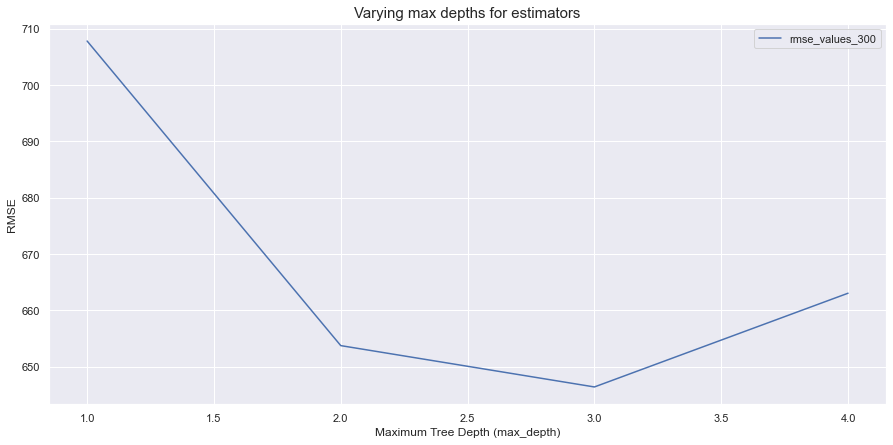

In [43]:
max_depths = [None, 1, 2, 3, 4]

plt.figure(figsize=(15, 7))
plt.title("Varying max depths for estimators", fontsize=15)

plt.grid("on")

def calc_score_for_varying_maxdepths(max_depths, n_est=300, learningr=0.1):
    rmse_values = []

    for depth in max_depths:
        gb_reg = GradientBoostingRegressor(max_depth=depth, n_estimators=n_est, learning_rate=learningr, random_state=2)
        gb_reg.fit(X_train, y_train)
        y_pred = gb_reg.predict(X_test)
        rmse_values.append(np.sqrt(MSE(y_test, y_pred)))
    
    return rmse_values

rmse_values_300 = calc_score_for_varying_maxdepths(max_depths)

plt.plot(max_depths, rmse_values_300, label="rmse_values_300")

plt.xlabel("Maximum Tree Depth (max_depth)")
plt.ylabel("RMSE")

plt.legend()
plt.show()


A **max_depth** value of 3 gives the best results.

#### Subsample

`subsample` is a subset of samples. Since samples are the rows, a subset of rows means that all rows may not be included when building each tree. By changing `subsample` from **1.0** to a smaller decimal, tree only select that percentage of samples during the build phase. For example `subsample=0.8` would select 80% of samples for each tree.

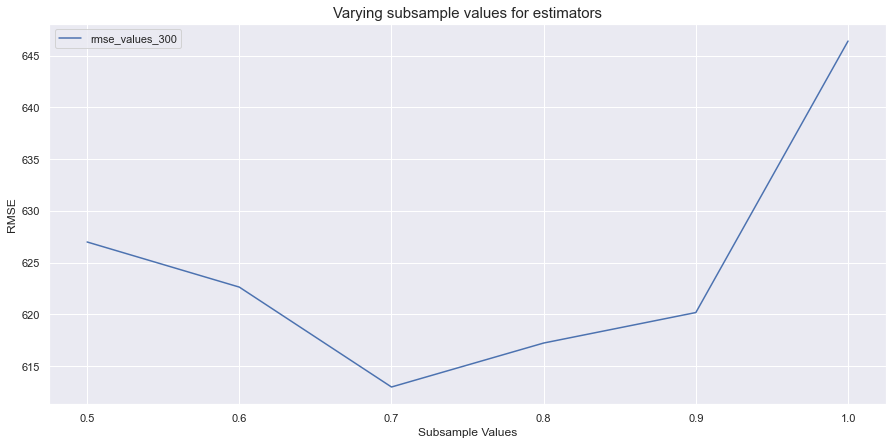

In [44]:
subsample_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]

plt.figure(figsize=(15, 7))
plt.title("Varying subsample values for estimators", fontsize=15)

plt.grid("on")

def calc_score_for_varying_subsamples(subsample_values, mdept= 3, n_est=300, learningr=0.1):
    rmse_values = []

    for value in subsample_values:
        gb_reg = GradientBoostingRegressor(max_depth=mdept, n_estimators=n_est, learning_rate=learningr, subsample=value, random_state=2)
        gb_reg.fit(X_train, y_train)
        y_pred = gb_reg.predict(X_test)
        rmse_values.append(np.sqrt(MSE(y_test, y_pred)))
    
    return rmse_values

rmse_values_300 = calc_score_for_varying_subsamples(subsample_values)

plt.plot(subsample_values, rmse_values_300, label="rmse_values_300")

plt.xlabel("Subsample Values")
plt.ylabel("RMSE")

plt.legend()
plt.show()

A **subsample** value of **0.7** with 300 trees and max_depth of 3 produces the best score yet: **612.988**

When subsample is not equal to 1.0, the model is classified as **stochastic gradient descent**, where stochastic indicates that some randomness is inherit in the model.

#### Searching Further with RandomizedSearchCV

Our preliminary analysis centered around `max_depth=3`, `subsample=0.7`, `n_estimators=300`, and `learning_rate=0.1` is a good place to start. Also we have already shown that as *n_estimators* goes up, *learning_rate* should go down.

In [54]:
from sklearn.model_selection import RandomizedSearchCV

params = {  'subsample': [0.7, 0.75, 0.8], 
            'n_estimators': [1200, 1600, 1800],
            'learning_rate': [0.02, 0.03, 0.05]}

gb_reg = GradientBoostingRegressor(max_depth=3, random_state=2)

rand_reg = RandomizedSearchCV(gb_reg, params, n_iter=10, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, random_state=2)

rand_reg.fit(X_train, y_train)

best_model = rand_reg.best_estimator_
best_params = rand_reg.best_params_
print(f"Best Params: {best_params}")
print(f"Best Score: {np.sqrt(-rand_reg.best_score_)}")

y_pred =  best_model.predict(X_test)
print(f"Test Score: {np.sqrt(MSE(y_test, y_pred))}")

Best Params: {'subsample': 0.7, 'n_estimators': 1200, 'learning_rate': 0.03}
Best Score: 633.085390802363
Test Score: 598.581059029657


With a larger value for **n_estimators** at 1200, a smaller **learning_rate** value at 0.03, we obtained the best *RMSE* yet at **598.58**

## Try with XGBoost

The only difference in hyperparameters from the last section is that XGBoost refers to *learning_rate* as **eta**

In [55]:
from xgboost import XGBRegressor

xg_reg = XGBRegressor(max_depth=3, n_estimators= 1200, eta=0.03, subsample=0.7, random_state=2)

xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

print(f"Test Score: {np.sqrt(MSE(y_test, y_pred))}")

Test Score: 588.9566690527543


The score is better. Accuracy and speed are two most important concepts when building machine learning models, and we have shown multiple times that XGBoost is very accurate.

- XGBoost is preferred over gradient boosting in general because it consistently delivers better results, and because it's faster.

## Approaching Big Data

In this part, *exoplanets* dataset (from Kaggle - *kepler-labelled-time-series-data*, 2017) will be used. The dataset has 5,087 rows and 3,189 columns that record light flux at different times of a star's life cycle. Multiplying rows and columns together results in 1.5 million datapoints. Using a baseline of 100 trees, we need 150 million data points to build a model.

- Each row is an individual star and columns reveals different light patterns over time.
- An exoplanet column is labeled 2 if the star hosts an exoplanet, otherwise it is labeled 1.

*Light Flux*: Percieved brightness of a star. When the light flux of an individual star changes periodically, it is possible that the star is being orbited by an exoplanet.

**Important Note**: Finding exoplanets is rare. The predictive column, on whether a star hosts an exoplanet or not, has very few positive cases, resulting in an imbalanced dataset. Imbalanced datasets require extra precautions.

In [56]:
df_exo = pd.read_csv("data/exoplanets.csv")
df_exo.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [57]:
df_exo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [58]:
df_exo.isnull().sum().sum()

0

The output reveals that there are no null values. Since all columns are numerical with no null values, we may split the dataset into training and test sets. Note that the **0th** columns is the target column *y*, and all other columns are the predictor columns.

In [59]:
X = df_exo.iloc[:, 1:]
y = df_exo.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

It is now time to build a gradient boosting classifier to predict whether stars host exoplanets. 

- Gradient boosting classifiers work in the same manner as gradient boosting regressors. The difference is primarily in the scoring.

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [61]:
import time

start = time.time()

gb_cls = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=2)

gb_cls.fit(X_train, y_train)

y_pred = gb_cls.predict(X_test)

score = accuracy_score(y_pred, y_test)

print(f"Score: {score}")

end = time.time()

print(f"Run time: {end - start} seconds")


Score: 0.9874213836477987
Run time: 235.8697280883789 seconds


**GradientBoostingClassifier** took around 4 minutes to run on 2017 MacBook Air. Not bad for 150 million data points on an older computer.

- While a score of 98.7% percent is usually outsanding, this is not the case with imbalanced datasetes.

In [62]:
start = time.time()

xg_cls = XGBClassifier(n_estimators=100, max_depth=2, random_state=2)
xg_cls.fit(X_train, y_train)

y_pred = xg_cls.predict(X_test)

score = accuracy_score(y_test, y_pred)

print(f"Score: {score}")

end = time.time()

print(f"Run time: {end - start} seconds")


[19:15:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.9913522012578616
Run time: 47.15296411514282 seconds


In this computer setup (1,8 GHz Dual-Core Intel i5, 8GB Memory) the process took under a minute. Almost 5 times faster, and bit more accurate than *GradientBoostingClassifier*.

- When it comes to big data, say an algorithm twice as fast can save weeks or months of computational time and resources. This advantage is huge. 